In [1]:
from torchvision import models
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
# Apply the transformations needed
import torchvision.transforms as T

import sys
sys.path.append('..')
from opencv_course import ImageUtil

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [2]:
net = dlab
path = './images/change/girl4.jpg'
img = Image.open(path)
if np.array(img).shape[2] == 4:
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGRA2BGR);
    img = Image.fromarray(img)

# Comment the Resize and CenterCrop for better inference results
trf = T.Compose([T.Resize(450), 
               #T.CenterCrop(224), 
               T.ToTensor(), 
               T.Normalize(mean = [0.485, 0.456, 0.406], 
                           std = [0.229, 0.224, 0.225])])
#GPU
#     inp = trf(img).unsqueeze(0).to(dev)
#     out = net.to(dev)(inp)['out']
#CPU
inp = trf(img).unsqueeze(0)
out = net(inp)['out']

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

<Figure size 720x720 with 0 Axes>

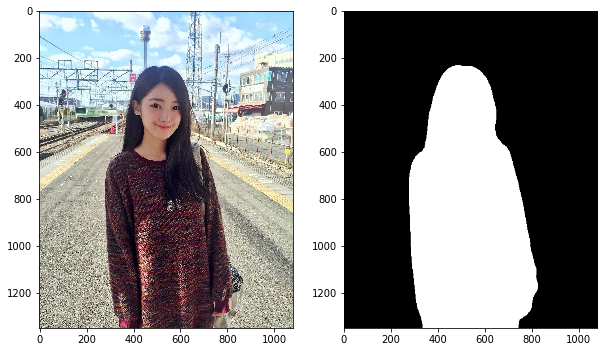

In [3]:
# Define the helper function
image = om
source = path
nc=21
#最好把要自动勾选的物体变成白色
label_colors = np.array([(0, 0, 0),  # 0=background
           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
           (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
           (0, 0, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

r = np.zeros_like(image).astype(np.uint8)
g = np.zeros_like(image).astype(np.uint8)
b = np.zeros_like(image).astype(np.uint8)

for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]


rgb = np.stack([r, g, b], axis=2)

# Load the foreground input image 
foreground = cv2.imread(source)

rgb = cv2.resize(rgb, (foreground.shape[1], foreground.shape[0]))

ImageUtil.imshow([foreground, rgb], columns=2,figsize=(10,10))

In [4]:
def dodgeNaive(image, mask):
    # determine the shape of the input image
    width, height = image.shape[:2]
 
    # prepare output argument with same size as image
    blend = np.zeros((width, height), np.uint8)
 
    for col in range(width):
        for row in range(height):
            # do for every pixel
            if mask[col, row] == 255:
                # avoid division by zero
                blend[col, row] = 255
            else:
                # shift image pixel value by 8 bits
                # divide by the inverse of the mask
                tmp = (image[col, row] << 8) / (255 - mask)
                # print('tmp={}'.format(tmp.shape))
                # make sure resulting value stays within bounds
                if tmp.any() > 255:
                    tmp = 255
                    blend[col, row] = tmp
 
    return blend

def dodgeV2(image, mask):
    return cv2.divide(image, 255 - mask, scale=256)

def burnV2(image, mask):
    return 255 - cv2.divide(255 - image, 255 - mask, scale=256)

<Figure size 1080x720 with 0 Axes>

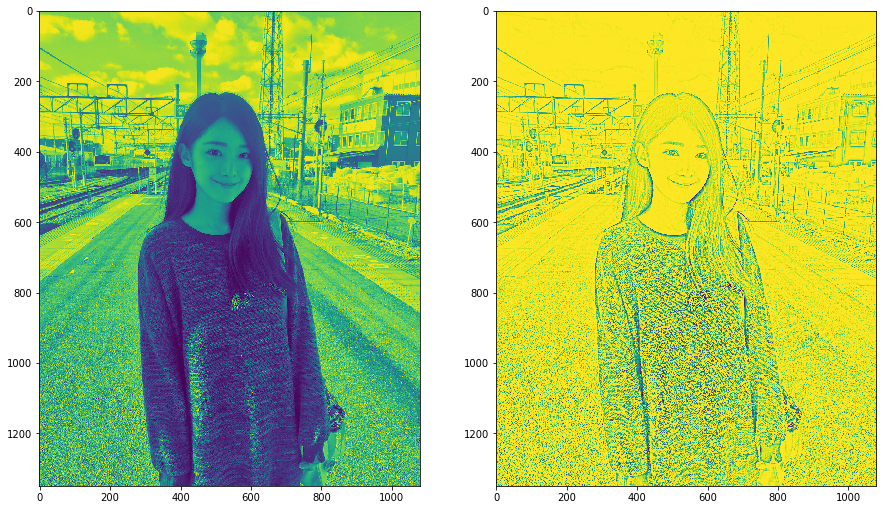

In [5]:
# Change the color of foreground image to RGB 
# and resize image to match shape of R-band in RGB output map  
foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(foreground,(rgb.shape[1],rgb.shape[0]))

img_gray_inv = 255 - img_gray
img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21), sigmaX=0, sigmaY=0)
img_blend = dodgeV2(img_gray, img_blur)

ImageUtil.imshow([foreground, img_blend], columns=2, figsize=(15,10), cvtColor=None)

<Figure size 720x720 with 0 Axes>

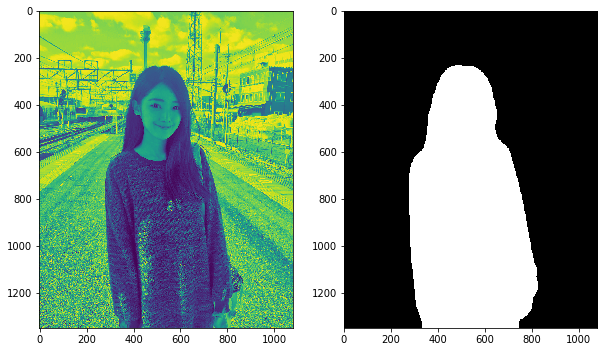

In [6]:
# Convert uint8 to float
foreground_float = foreground.astype(float)
img_blend = img_blend.astype(float)

# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

ImageUtil.imshow([foreground, alpha], columns=2, figsize=(10,10), cvtColor=None)

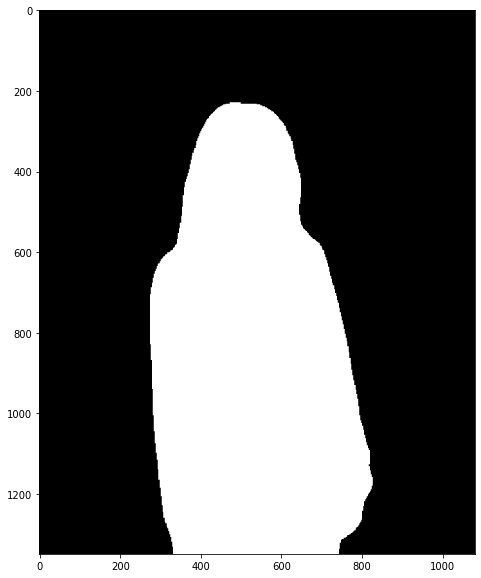

In [7]:
# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (3,3),0)

ImageUtil.imshow([alpha], figsize=(10,10))

In [8]:
# Normalize the alpha mask to keep intensity between 0 and 1
alpha_float = alpha.astype(float)/255

# Multiply the foreground with the alpha matte
foreground_float = cv2.multiply(alpha_float, foreground_float)

ImageUtil.imshow([foreground_float.astype('uint8')], figsize=(10,10), cvtColor=None)

error: OpenCV(4.1.1) /Users/kevinzjpeng/文档/课程/source/opencv/modules/core/src/arithm.cpp:663: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [9]:
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha_float, oilPainted)  

ImageUtil.imshow([background.astype('uint8')], figsize=(10,10), cvtColor=None)

NameError: name 'oilPainted' is not defined

In [10]:
# Add the masked foreground and background
outImage = cv2.add(foreground_float, background)

ImageUtil.imshow([foreground, outImage.astype('uint8')], columns =2, figsize=(10,10), cvtColor=None)

NameError: name 'background' is not defined

In [11]:
# Return a normalized output image for display
rgb = outImage/255

ImageUtil.imshow([np.array(img), np.array(rgb)], columns=2, rows=1, figsize=(15,10), cvtColor=None)

NameError: name 'outImage' is not defined